In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import json
import xsim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from collections import namedtuple


In [4]:
from qml.db import dpo as xdpo
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model
from qml.optimizer import dpo as xdpopt
from qml.optimizer import evaluator as xeval
from qml.tools.random import XRandomGenerator
from qml.tools.sampler import CandidateSampler
from qml import optimizer as xoptim
from qml.tools.config import Config
from qml.tools.validation import validate


# Training w/o new gata generation
## Steps
1. Prepare
1-1. policy and ref
1-2. 
2. Main loop
2-1. train epoch
2-2. validate

## Prepare

### Prepare QML DB

In [5]:
def hard_copy(target, source):
    target.net.load_state_dict(source.net.state_dict())


In [6]:
def select_logps(logps, onehot):
    selected_logps = (logps.unsqueeze(1) * onehot).sum(dim=-1).sum(dim=-1)
    return selected_logps

def calc_logps(policy, batch, sampler):
    logits = policy(batch.wserieses)
    logps_gate, logps_qbit = sampler.as_logps(logits)
    logps_best = select_logps(logps_gate, batch.best.onehot_gindices) + select_logps(logps_qbit, batch.best.onehot_qubits)
    logps_others = select_logps(logps_gate, batch.others.onehot_gindices) + select_logps(logps_qbit, batch.others.onehot_qubits)
    return logps_best, logps_others


In [7]:
def calc_loss_dpo(logrp, logrp_ref, beta=0.5):
    return -1 * nn.functional.logsigmoid(beta * (logrp - logrp_ref)).mean()

def calc_loss_llh(logp_best):
    return torch.exp(logp_best).mean()


In [17]:
cf = Config("note/experiments/config.yaml")

In [18]:
dataset = xdpo.DPODataset(cf.dpo.training.db.filename, cf.nq, cf.ocg.dim_wavelet)
loader = xdpo.DPODataLoader(dataset, cf.nq, cf.dpo.training.db.batch_size, cf.ocg.dim_wavelet)


In [19]:
tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial)
tgen = MLDatasetGenerator(tfun)
validation_datasets = [
    tgen.generate(cf.dpo.validation.dbsize)
    for _ in range(cf.dpo.validation.num_db)
]

### Prepare policy

In [24]:
policy = xdpopt.Policy(
    cf.ocg.dim_wavelet,
    cf.nq,
    cf.ng,
    cf.ocg.policy.dim_hiddens,
)
reference = xdpopt.Policy(
    cf.ocg.dim_wavelet,
    cf.nq,
    cf.ng,
    cf.ocg.policy.dim_hiddens,
)

optimizer = optim.Adam(policy.parameters(), lr=cf.dpo.training.lr)
sampler = CandidateSampler(policy)

In [25]:
logger = xsim.Logger()

In [27]:

Loss = namedtuple("Loss", ["total", "dpo", "llh"])

def calc_logits(logits, cf):
    logits_gate, logits_qbit = sampler.divide_gate_and_qubit(logits)
    logits_gate = logits_gate.view(len(logits), cf.ng, -1)
    logits_qbit = logits_qbit.view(len(logits), cf.ng, -1)
    return logits_gate, logits_qbit

def select_logps(logits, onehot):
    logps = nn.functional.log_softmax(logits, dim=-1).unsqueeze(dim=1)
    selected_logps = (logps * onehot).sum(dim=-1).sum(dim=-1)
    return selected_logps

def calc_logps_(logits, subbatch):
    logits_gate, logits_qbit = logits
    logps_gate = select_logps(logits_gate, subbatch.onehot_gindices)
    logps_qbit = select_logps(logits_qbit, subbatch.onehot_qubits)
    logps = (logps_gate + logps_qbit).mean(dim=-1)
    return logps


def calc_logps(policy, batch, sampler, cf):
    logits = policy(batch.wserieses)
    logits = calc_logits(logits, cf)
    logps_best = calc_logps_(logits, batch.best)
    logps_others = calc_logps_(logits, batch.others)
    return logps_best, logps_others


def calc_loss_dpo(logps_pol_best, logps_pol_others, logps_ref_best, logps_ref_others, cf):
    dlogps_pol = logps_pol_best - logps_pol_others
    dlogps_ref = logps_ref_best - logps_ref_others
    ddlogps = dlogps_pol - dlogps_ref
    loss_dpo = -1 * nn.functional.logsigmoid(cf.dpo.training.beta * ddlogps).mean()
    return loss_dpo


def calc_loss_llh(logos_best):
    return torch.exp(logos_best).mean()


def train_once(policy, reference, optimizer, batch, sampler, cf):
    logps_pol_best, logps_pol_others = calc_logps(policy, batch, sampler, cf)
    logps_ref_best, logps_ref_others = calc_logps(reference, batch, sampler, cf)
    loss_dpo = calc_loss_dpo(logps_pol_best, logps_pol_others, logps_ref_best, logps_ref_others, cf)
    loss = loss_dpo

    if cf.dpo.training.cpo:
        loss_llh = calc_loss_llh(logps_pol_best)
        loss = loss_dpo + loss_llh
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return Loss(loss.item(), loss_dpo.item(), loss_llh.item())


for epoch in range(1, cf.dpo.training.num_epochs+1):
    epoch_losses = []
    for batch in loader:
        losses = train_once(policy, reference, optimizer, batch, sampler, cf)
        
        # logging
        epoch_losses.append(losses)

    loss = np.mean([loss.total for loss in epoch_losses])
    loss_dpo = np.mean([loss.dpo for loss in epoch_losses])
    print(f"epoch {epoch:>3}  loss: {loss:.4f}  dpo: {loss_dpo:.4f}", end="")
    if cf.dpo.training.cpo:
        loss_llh = np.mean([loss.llh for loss in epoch_losses])
        print(f"  llh: {loss_llh:.4f}")
    else:
        print()



epoch   1  loss: 0.4106  dpo: 0.4067  llh: 0.0039
epoch   2  loss: 0.4040  dpo: 0.4007  llh: 0.0033
epoch   3  loss: 0.3884  dpo: 0.3852  llh: 0.0032
epoch   4  loss: 0.3858  dpo: 0.3826  llh: 0.0032
epoch   5  loss: 0.3659  dpo: 0.3629  llh: 0.0030
epoch   6  loss: 0.3562  dpo: 0.3530  llh: 0.0032
epoch   7  loss: 0.3407  dpo: 0.3378  llh: 0.0028
epoch   8  loss: 0.3248  dpo: 0.3216  llh: 0.0032
epoch   9  loss: 0.3149  dpo: 0.3121  llh: 0.0028
epoch  10  loss: 0.3001  dpo: 0.2979  llh: 0.0022
epoch  11  loss: 0.2852  dpo: 0.2827  llh: 0.0025
epoch  12  loss: 0.2884  dpo: 0.2863  llh: 0.0021
epoch  13  loss: 0.2728  dpo: 0.2705  llh: 0.0022
epoch  14  loss: 0.2575  dpo: 0.2556  llh: 0.0019
epoch  15  loss: 0.2465  dpo: 0.2448  llh: 0.0017
epoch  16  loss: 0.2421  dpo: 0.2406  llh: 0.0016
epoch  17  loss: 0.2275  dpo: 0.2254  llh: 0.0021
epoch  18  loss: 0.2187  dpo: 0.2170  llh: 0.0017
epoch  19  loss: 0.2229  dpo: 0.2214  llh: 0.0015
epoch  20  loss: 0.2075  dpo: 0.2059  llh: 0.0016


In [197]:
for epoch in range(1, cf.dpo.training.num_epochs+1):
    print(f"Epoch {epoch:>3}", end="")
    hard_copy(reference, policy)
    epoch_losses = []
    epoch_losses_dpo = []
    epoch_losses_llh = []
    
    for batch in loader:

        
        logps_best, logps_others = calc_logps(policy, batch, sampler)
        logps_ref_best, logps_ref_others = calc_logps(reference, batch, sampler)

        logps_best = logps_best.mean(dim=-1)
        logps_others = logps_others.mean(dim=-1)
        logps_ref_best = logps_ref_best.mean(dim=-1)
        logps_ref_others = logps_ref_others.mean(dim=-1)

        print(torch.exp(logps_best - logps_others), logps_best - logps_others)
        break

        loss_dpo = calc_loss_dpo(
            logps_best - logps_others,
            logps_ref_best - logps_ref_others,
        )
        loss = loss_dpo

        if cf.dpo.training.cpo:
            loss_llh = calc_loss_llh(logps_best)
            loss = loss + loss_llh

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        epoch_losses.append(loss.item())
        epoch_losses_dpo.append(loss_dpo.item())
        if cf.dpo.training.cpo:
            epoch_losses_llh.append(loss_llh.item())
    
    # break
    print(f" loss: {epoch_loss:.4f}")

    # validation
    # if epoch % cf.dpo.validation.interval == 0:
    #     vloss = validate(sampler, validation_datasets, cf.nq, cf.dpo.validation.num_rounds, cf.qml.num_train, cf.ocg.dim_wavelet, xeval.Haar())
    #     print(f" Validation loss: {vloss:.4f}")

    # logging
    epoch_loss = np.mean(epoch_losses)
    epoch_loss_dpo = np.mean(epoch_losses_dpo)
    if cf.dpo.training.cpo:
        epoch_loss_llh = np.mean(epoch_losses_llh)
    
    
    logger.store(
        epoch=epoch,
        epoch_loss=epoch_loss,
        epoch_loss_dpo=epoch_loss_dpo,
    )
    if cf.dpo.training.cpo:
        logger.store(
            epoch_loss_llh=epoch_loss_llh,
        )
    logger.flush()


Epoch   1tensor([inf, inf, inf, 0., inf, inf, inf, inf, inf, inf],
       grad_fn=<ExpBackward0>) tensor([13577.5947,  2173.0938, 17909.7969, -6251.5625, 84437.5781,  5160.1094,
        37395.2422,  9316.8926, 52818.6953, 12460.6172],
       grad_fn=<SubBackward0>)
 loss: nan
Epoch   2tensor([       inf,        inf, 8.4592e-36,        inf,        inf, 0.0000e+00,
               inf,        inf,        inf,        inf],
       grad_fn=<ExpBackward0>) tensor([12328.3672, 80003.8125,   -80.7578,  6364.3164, 17909.7969,  -533.5820,
        28557.1250, 11476.1133,  8950.0234, 43547.7188],
       grad_fn=<SubBackward0>)
 loss: nan
Epoch   3tensor([inf, 0., inf, 0., inf, inf, inf, inf, inf, inf],
       grad_fn=<ExpBackward0>) tensor([  9972.1445,  -1940.4121,   7300.2578, -12739.1914,  28671.8594,
          4389.8379,  13551.9062,   8598.3105,  10669.0703,   5413.0820],
       grad_fn=<SubBackward0>)
 loss: nan
Epoch   4tensor([inf, inf, inf, inf, inf, 0., 0., inf, inf, inf],
       grad_fn=

In [147]:
validation_datasets[0].xs

array([ 0.88997272,  0.24719483, -0.5681632 , -0.35359916,  0.41313979,
       -0.71273875,  0.40802407,  0.27089185, -0.15108077, -0.20369343])

<Axes: xlabel='epoch'>

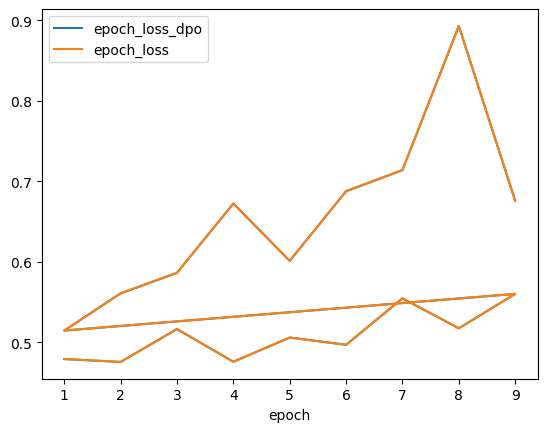

In [136]:
ret = xsim.Retriever(logger)
res = pd.DataFrame(dict(
    epoch=ret.epoch(),
    epoch_loss=ret.epoch_loss(),
    epoch_loss_dpo=ret.epoch_loss_dpo(),
    # epoch_loss_llh=ret.epoch_loss_llh(),
))

res.plot(x="epoch", y=["epoch_loss_dpo", "epoch_loss"])

In [198]:
np.log(0.01)

np.float64(-4.605170185988091)